In [1]:
import pandas as pd 
import networkx as nx
import matplotlib.pyplot as plt
from pathlib import Path
import graspologic as gl
from celegans_connectome_analysis.get_nx import get_adult_c_elegans_nx,get_fxnl_nx

In [2]:
G_fx = get_fxnl_nx()
G_stx = get_adult_c_elegans_nx()

/home/gwyneth-local/celegans_connectome_analysis/celegans_connectome_analysis/get_nx.py:28: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["neuron type"] = df["neuron type"].fillna(method='ffill')


In [3]:
# goal: make a di_graph that contants functional and structural information
fx_nodes = set(G_fx.nodes())
stx_nodes = set(G_stx.nodes())

print(stx_nodes - fx_nodes)
print(fx_nodes - stx_nodes)

{'PVR', 'RMHL', 'BWM-VL04', 'BWM-DL02', 'BWM-VR07', 'RIPR', 'BWM-VL03', 'CEPshVR', 'BWM-VL06', 'BWM-DL01', 'BWM-DL08', 'ALNR', 'BWM-DL05', 'BWM-DR01', 'CANL', 'ALMR', 'BWM-VL07', 'PLNL', 'GLRDL', 'ALML', 'SIBVL', 'ADFR', 'ALNL', 'BWM-VL01', 'BDUR', 'GLRR', 'HSNR', 'BWM-VR04', 'BWM-DR06', 'PVQR', 'CANR', 'BWM-VR01', 'BWM-DL04', 'SIAVL', 'BWM-DR07', 'PVPL', 'SIADL', 'BWM-DR03', 'SIBDR', 'BWM-DR08', 'RIFL', 'RMHR', 'PVPR', 'BDUL', 'PVCR', 'GLRDR', 'CEPshVL', 'BWM-VR03', 'SDQL', 'PLNR', 'BWM-VR05', 'AIAL', 'SIBDL', 'PVNR', 'SIAVR', 'GLRVR', 'BWM-DR05', 'DVC', 'IL1L', 'PVQL', 'PVT', 'BWM-DL07', 'GLRL', 'BWM-VL02', 'HSNL', 'BWM-DR02', 'BWM-DL06', 'GLRVL', 'SDQR', 'BWM-VR06', 'AVM', 'BWM-VR02', 'BWM-VL05', 'SIADR', 'DVA', 'CEPshDR', 'PVNL', 'CEPshDL', 'BWM-DL03', 'AVFR', 'BWM-VL08', 'BWM-VR08', 'AIAR', 'BWM-DR04', 'IL2VR', 'PVCL'}
{'I2R', 'M5', 'M2R', 'DB2', 'VB1', 'VB2', 'IL2V4', 'M3L', 'I6', 'AS1', 'MCL', 'MI', 'I3', 'SABD', 'DA1', 'I1L', 'DD1', 'I4', 'I2L', 'I1R', 'MCR', 'VA1', 'AVG', 'NSM

In [4]:
def combined_graph(stx, fx):
    G = nx.DiGraph()
    transfer_info(G, fx, 'fx_weight')
    transfer_info(G, stx, 'stx_weight')
    return G

def transfer_info(G: nx.DiGraph, source: nx.DiGraph, weight_label: str):
    for node in source.nodes():
        if node not in G.nodes():
            G.add_node(node)
        
        G.nodes[node]['neuron type'] = source.nodes[node]['neuron type']
        # add out edge information
        for target, infos in source[node].items():
            if not G.has_edge(node, target):
                G.add_edge(node, target)
            renamed_infos = {weight_label: infos['weight']}
            G[node][target].update(renamed_infos)

In [29]:
G = combined_graph(G_stx, G_fx)
print(G)

DiGraph with 254 nodes and 5108 edges


In [5]:
# mini tests

# test 1: check if all fx nodes are in G
def check_fx(G: nx.DiGraph, fx_nodes: set):
    for node in fx_nodes:
        assert node in G.nodes(), f"Node {node} not in G"

# test 2: check if all stx nodes are in G
def check_stx(G: nx.DiGraph, stx_nodes: set):
    for node in stx_nodes:
        assert node in G.nodes(), f"Node {node} not in G"

# test 3: check if all fx edges are in G and weights match
def check_fx_edges(G: nx.DiGraph, fx: nx.DiGraph):
    for node in fx.nodes():
        for target, infos in fx[node].items():
            assert G[node][target]['fx_weight'] == infos['weight'], f"Weight mismatch between G and fx"

# test 4: check if all stx edges are in G and weights match
def check_stx_edges(G: nx.DiGraph, stx: nx.DiGraph):
    for node in stx.nodes():
        for target, infos in stx[node].items():
            assert G[node][target]['stx_weight'] == infos['weight'], f"Weight mismatch between G and stx"

# test 5: check if all nodes have stx neuron type attribute
def check_neuron_type(G: nx.DiGraph, stx: nx.DiGraph):
    for node in stx.nodes():
        assert G.nodes[node]['neuron type'] == stx.nodes[node]['neuron type'], f"Neuron type mismatch between G and stx"

In [31]:
# run tests
check_fx(G, fx_nodes)
check_stx(G, stx_nodes)
check_fx_edges(G, G_fx)
check_stx_edges(G, G_stx)
check_neuron_type(G, G_stx)

In [9]:
# save graph
nx.write_gpickle(G, 'combined_graph.gpickle')

In [6]:
# load and test
G_loaded = nx.read_gpickle('data/combined_graph.gpickle')
check_fx(G_loaded, fx_nodes)
check_stx(G_loaded, stx_nodes)
check_fx_edges(G_loaded, G_fx)
check_stx_edges(G_loaded, G_stx)
check_neuron_type(G_loaded, G_stx)

In [7]:
muscle_nodes = [n for n in G_loaded.nodes if G_loaded.nodes[n]["neuron type"] == "Muscle"]

# Remove muscle nodes from G_loaded
G_loaded.remove_nodes_from(muscle_nodes)

In [8]:
category_order = {'Sens.': 0, 'Inter.': 1, 'Mot.': 2, 'Mod.': 3, 'Other': 4}

ordered_nodes = sorted(G_loaded.nodes(), key=lambda n: (category_order[G_loaded.nodes[n]["neuron type"]], -1 * (n in G_fx.nodes() and n in G_stx.nodes())))

stx_adj_matrix = nx.adjacency_matrix(G_loaded, nodelist=ordered_nodes, weight='stx_weight').todense()
fx_adj_matrix = nx.adjacency_matrix(G_loaded, nodelist=ordered_nodes, weight='fx_weight').todense()

neuron_types = [G_loaded.nodes[n]["neuron type"] for n in ordered_nodes]

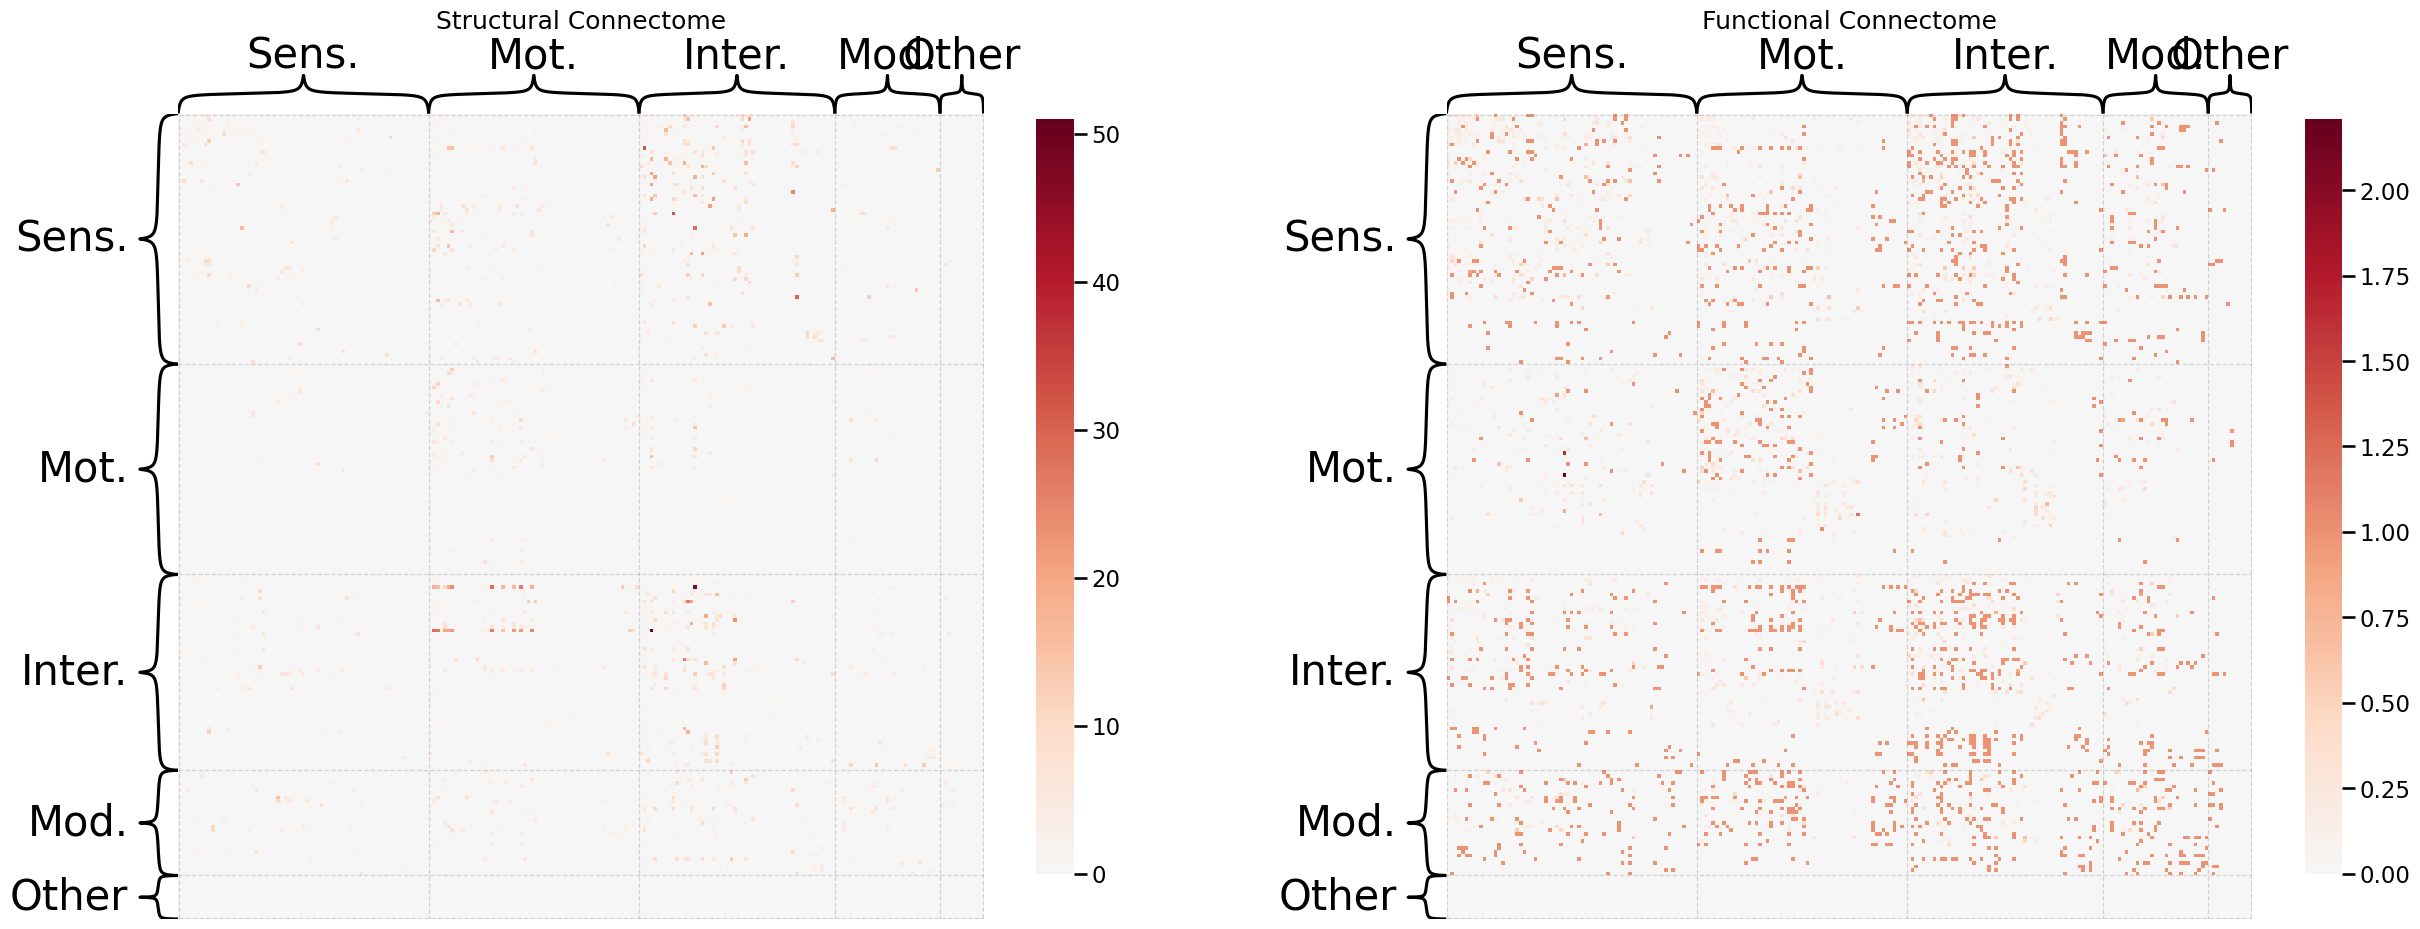

In [12]:
import numpy as np
stx_adj = np.asarray(stx_adj_matrix)
fx_adj = np.asarray(fx_adj_matrix)

title = "Side-by-side Connectomes for Structural and Functional Neuron Data"
fig, axes = plt.subplots(1, 2, figsize=(30, 14))

# Plot structural adjacency matrix
gl.plot.heatmap(stx_adj, inner_hier_labels=neuron_types, sort_nodes=False, title="Structural Connectome", ax=axes[0], cbar=True)

# Plot functional adjacency matrix
gl.plot.heatmap(fx_adj, inner_hier_labels=neuron_types, sort_nodes=False, title="Functional Connectome", ax=axes[1], cbar=True)

plt.show()


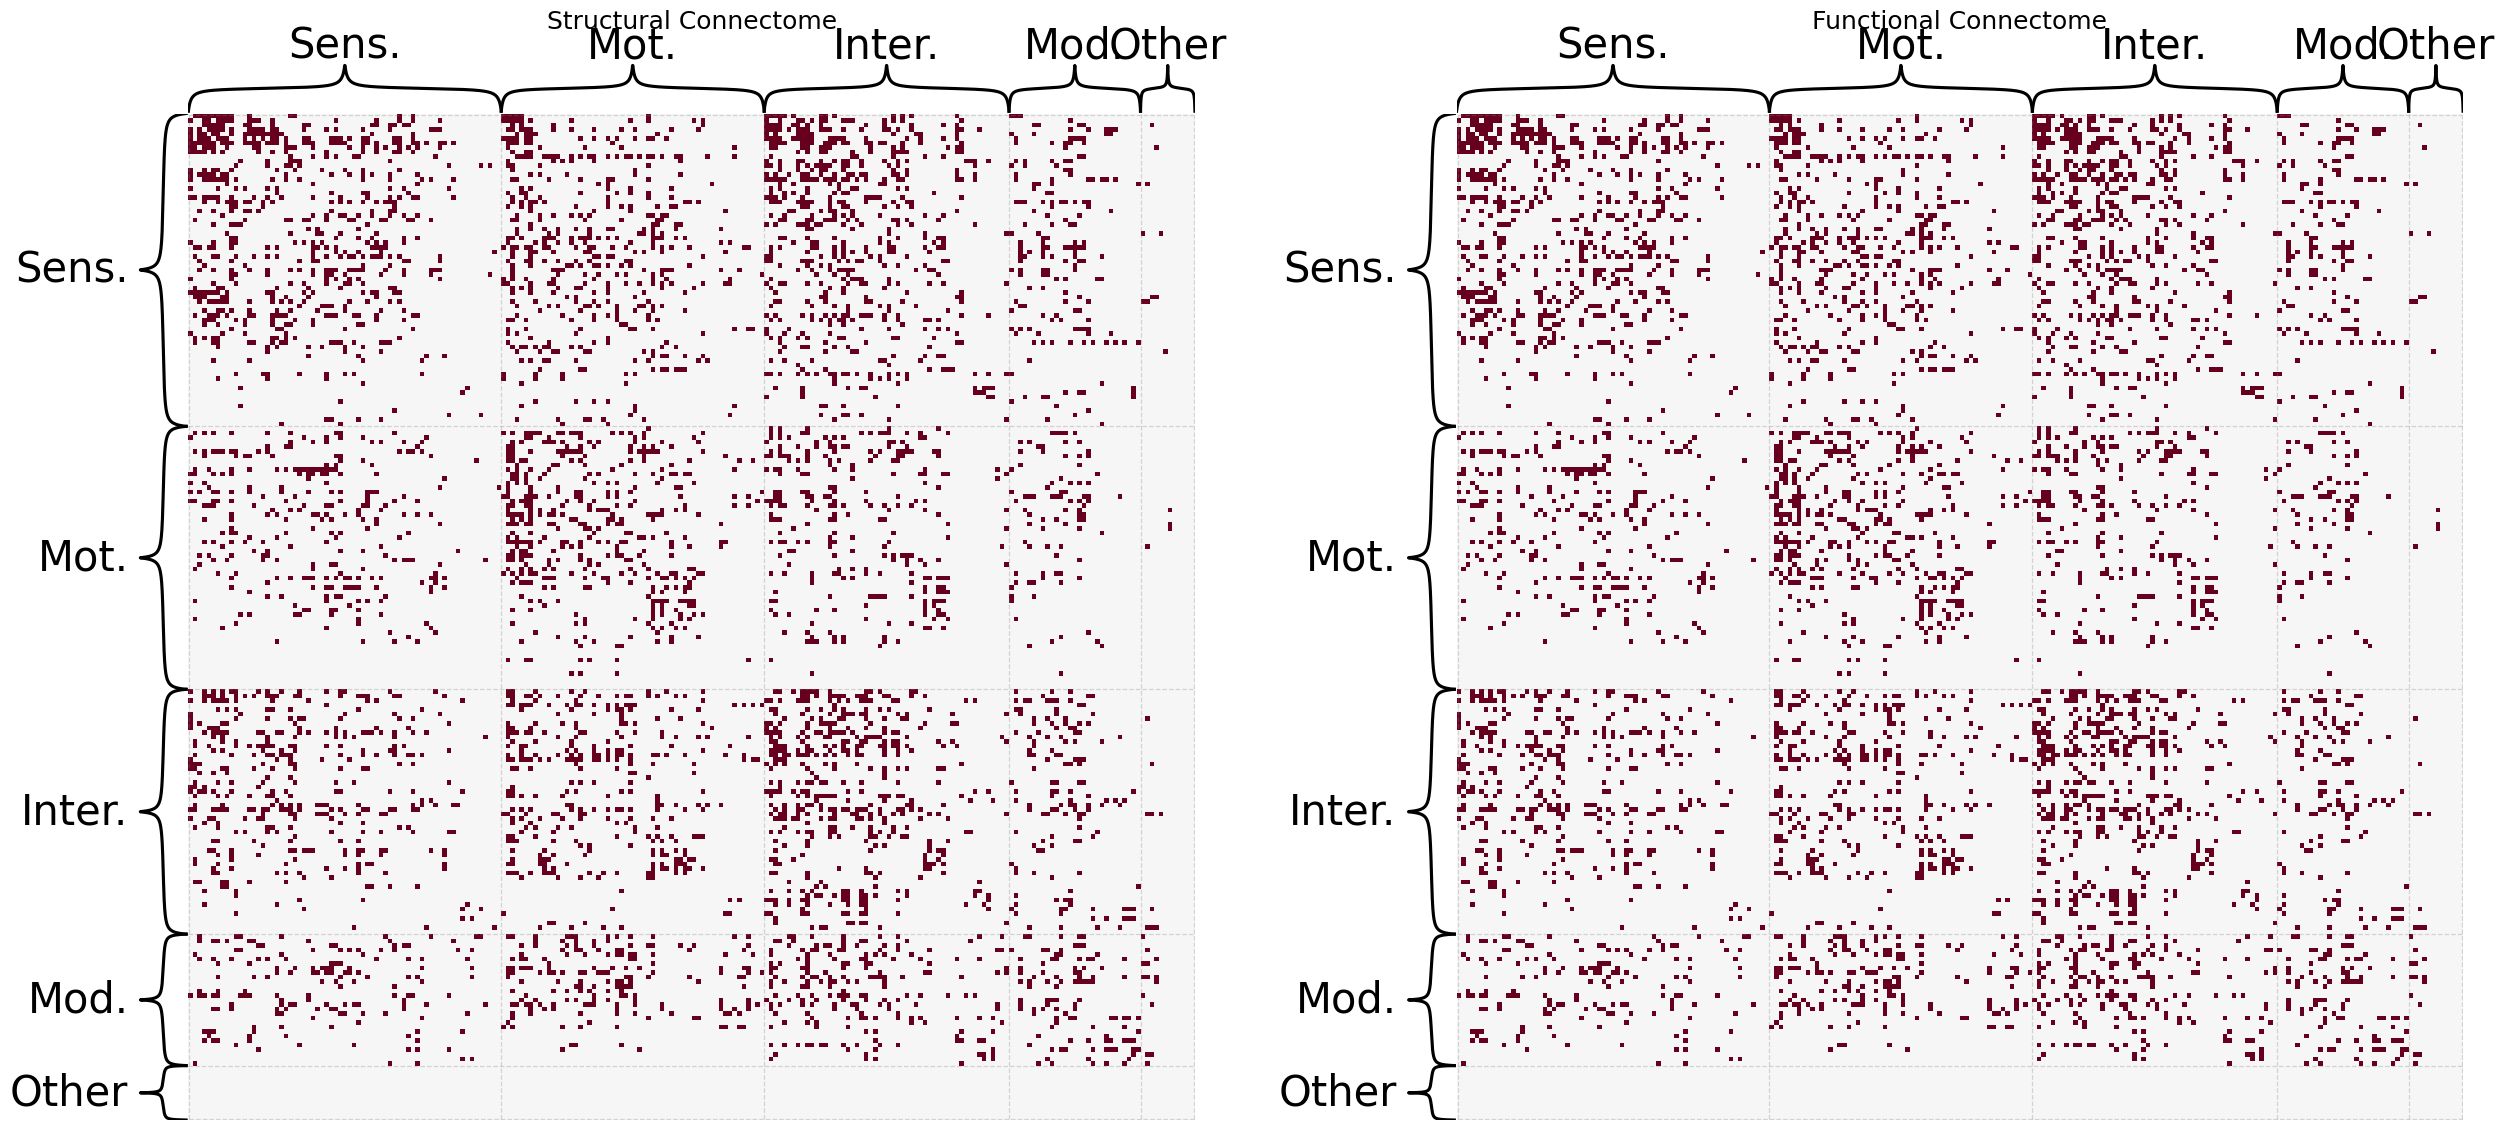

In [13]:
title = "Side-by-side Connectomes for Structural and Functional Neuron Data"
fig, axes = plt.subplots(1, 2, figsize=(30, 14))

# Plot structural adjacency matrix
gl.plot.heatmap(stx_adj>0, inner_hier_labels=neuron_types, sort_nodes=False, title="Structural Connectome", ax=axes[0], cbar=False)

# Plot functional adjacency matrix
gl.plot.heatmap(fx_adj>0, inner_hier_labels=neuron_types, sort_nodes=False, title="Functional Connectome", ax=axes[1], cbar=False)
plt.show()

In [14]:
binarized_stx_adj = stx_adj > 0
binarized_fx_adj = fx_adj > 0

# Calculate the Jaccard similarity between the two connectomes
jaccard_similarity = np.sum(np.logical_and(binarized_stx_adj, binarized_fx_adj)) / np.sum(np.logical_or(binarized_stx_adj, binarized_fx_adj))
print(f"Jaccard similarity: {jaccard_similarity}")

Jaccard similarity: 1.0


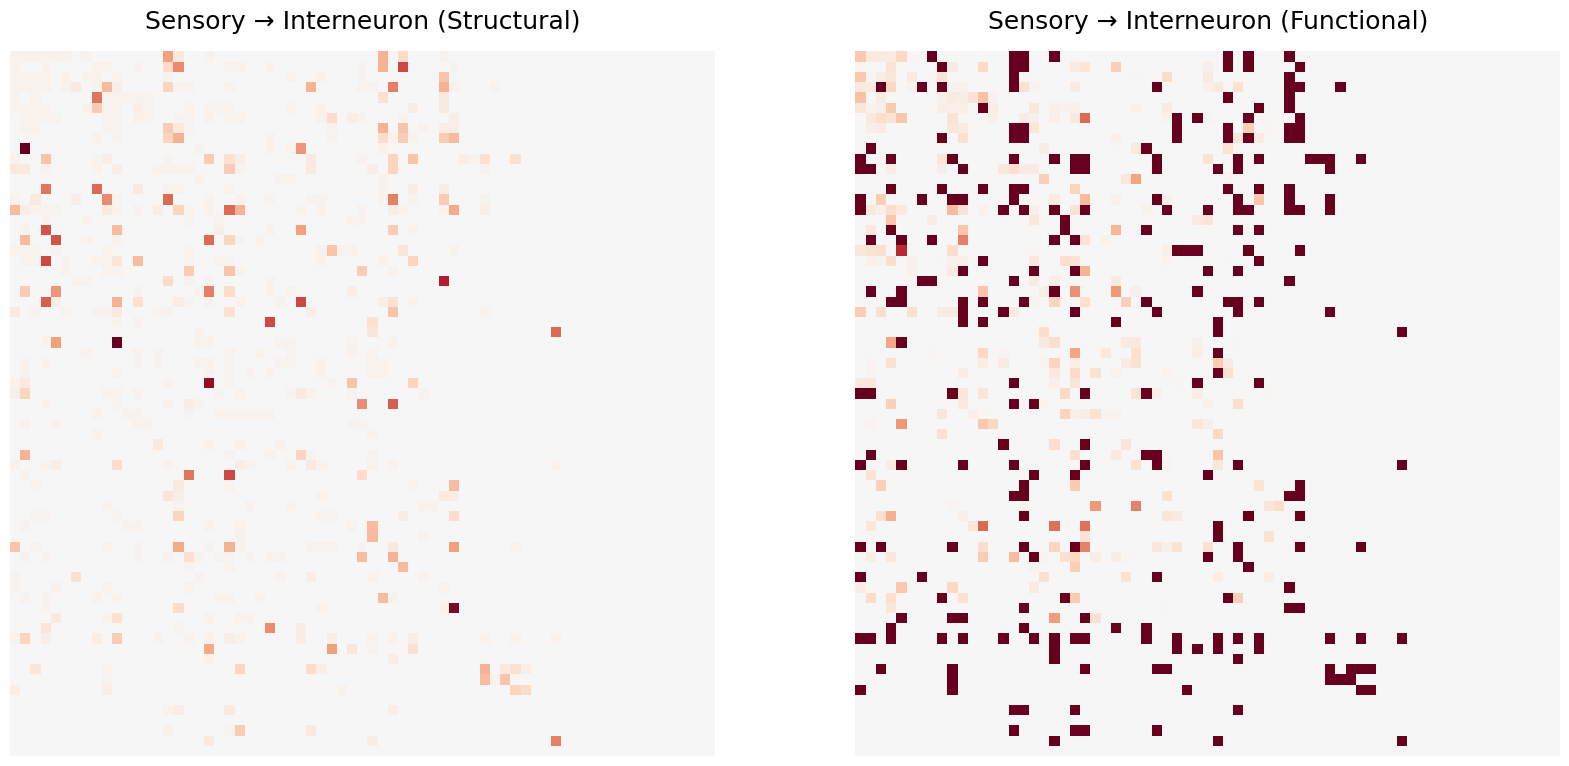

In [18]:
# zoom in on sensory to neuron connections
sensory_nodes = [n for n in G_loaded.nodes if G_loaded.nodes[n]["neuron type"] == "Sens."]
sensory_indices = [ordered_nodes.index(n) for n in sensory_nodes]
interneuron_nodes = [n for n in G_loaded.nodes if G_loaded.nodes[n]["neuron type"] == "Inter."]
interneuron_indices = [ordered_nodes.index(n) for n in interneuron_nodes]

sub_stx_adj = stx_adj[np.ix_(sensory_indices, interneuron_indices)]
sub_fx_adj = fx_adj[np.ix_(sensory_indices, interneuron_indices)]

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
rows_stx, cols_stx = sub_stx_adj.shape
rows_fx, cols_fx = sub_fx_adj.shape

max_size = max(rows_stx, cols_stx)

padded_sub_stx_adj = np.zeros((max_size, max_size))
padded_sub_fx_adj = np.zeros((max_size, max_size))

padded_sub_stx_adj[:rows_stx, :cols_stx] = sub_stx_adj
padded_sub_fx_adj[:rows_fx, :cols_fx] = sub_fx_adj

gl.plot.heatmap(padded_sub_stx_adj, title="Sensory → Interneuron (Structural)", ax=axes[0], sort_nodes=False, cbar=False)
gl.plot.heatmap(padded_sub_fx_adj, title="Sensory → Interneuron (Functional)", ax=axes[1], sort_nodes=False, cbar=False)
plt.show()

In [20]:
matrices = {'stx_adj': stx_adj, 'fx_adj': fx_adj, 'sub_stx_adj': sub_stx_adj, 'sub_fx_adj': sub_fx_adj}
matrix_db = pd.DataFrame(columns=['Matrix', 'Shape', 'Rank', 'Non-zero Entries'])
for matrix_name, matrix in matrices.items():
    matrix_db.loc[len(matrix_db)] = [matrix_name, matrix.shape, np.linalg.matrix_rank(matrix), np.count_nonzero(matrix)]

matrix_db.head()

,Matrix,Shape,Rank,Non-zero Entries
0,stx_adj,"(222, 222)",202,4892
1,fx_adj,"(222, 222)",202,4892
2,sub_stx_adj,"(69, 54)",51,589
3,sub_fx_adj,"(69, 54)",51,589


In [23]:
# compute correlation between stx_weight and fx_weight
weights = pd.DataFrame(columns=['stx_weight', 'fx_weight', 'source_type', 'target_type'])
G = G_loaded
for u, v in G.edges:
    fx_weight = 0
    stx_weight = 0
    if 'fx_weight' in G[u][v]:
        fx_weight = G[u][v]['fx_weight']
    if 'stx_weight' in G[u][v]:
        stx_weight = G[u][v]['stx_weight']
    weights.loc[len(weights)] = [stx_weight, 
                                fx_weight,
                                G.nodes[u]['neuron type'],
                                G.nodes[v]['neuron type']]

weights.head()

,stx_weight,fx_weight,source_type,target_type
0,0.0,0.007183,Sens.,Mod.
1,0.0,0.275504,Sens.,Sens.
2,2.0,0.202251,Sens.,Sens.
3,0.0,0.208043,Sens.,Sens.
4,0.0,0.165396,Sens.,Sens.


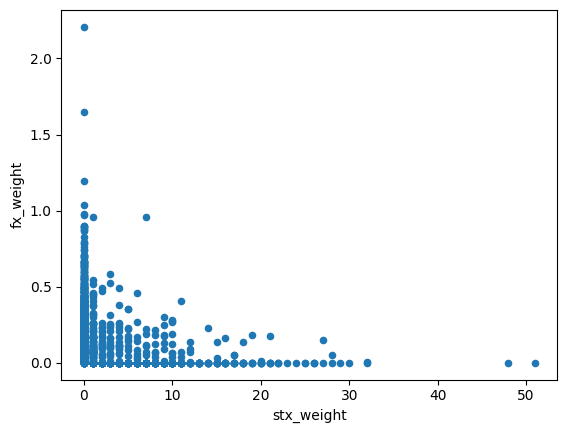

In [24]:
weights.plot.scatter(x='stx_weight', y='fx_weight')
plt.show()

In [27]:
# test significance of correlation using Pearson test
from scipy.stats import pearsonr

# all edges
print("All edges")
r_all, p_all = pearsonr(weights['stx_weight'], weights['fx_weight'])
print(f"R: {r_all}, p-value: {p_all}")

sens_to_intern = weights[(weights['source_type'] == 'Sens.') & (weights['target_type'] == 'Inter.')]
r_sens_intern, p_sens_intern = pearsonr(sens_to_intern['stx_weight'], sens_to_intern['fx_weight'])
print(f"R: {r_sens_intern}, p-value: {p_sens_intern}")


# significance without 0-weight edges
print("Non-zero edges")
# filter db based on non-zero edges
non_zero_weights = weights[(weights['stx_weight'] != 0) & (weights['fx_weight'] != 0)]

r_non_zero, p_non_zero = pearsonr(non_zero_weights['stx_weight'], non_zero_weights['fx_weight'])
print(f"R: {r_non_zero}, p-value: {p_non_zero}")

non_zero_sense_to_intern = non_zero_weights[(non_zero_weights['source_type'] == 'Sens.') & (non_zero_weights['target_type'] == 'Inter.')]
r_si_non_zero, p_si_non_zero = pearsonr(non_zero_sense_to_intern['stx_weight'], non_zero_sense_to_intern['fx_weight'])
print(f"R: {r_si_non_zero}, p-value: {p_si_non_zero}")


All edges
R: -0.23457783398426735, p-value: 3.856268908206208e-62
R: -0.2873686309185088, p-value: 1.16098028778524e-12
Non-zero edges
R: -0.11989634855756182, p-value: 0.0837788492538813
R: -0.1763357136571338, p-value: 0.35127269485245116


## Analysis on Amphids Circuit

Node types: gap junctions (T), synapses (arrows), sensory neurons (triangles), interneurons (hexagons), motorneurons (circles)
<img src="images/amphids.png" alt="Amphids Circuit Diagram" width="800"/>

In [28]:
# checking for all neurons existence in graph
# load G
G = nx.read_gpickle('data/combined_graph.gpickle')
egg_graph = nx.DiGraph()

sensory = {
    "ADF": ("ADFR", "ADFL"),
    "ADL": ("ADLR", "ADLL"),
    "AFD": ("AFDR", "AFDL"),
    "ASG": ("ASGR", "ASGL"),
    "ASH": ("ASHR", "ASHL"),
    "ASI": ("ASIR", "ASIL"),
    "ASJ": ("ASJR", "ASJL"),
    "ASK": ("ASKR", "ASKL"),
    "ASE": ("ASER", "ASEL"),
    "AUA": ("AUAR", "AUAL"),
    "AWA": ("AWAR", "AWAL"),
    "AWB": ("AWBR", "AWBL"),
    "AWC": ("AWCR", "AWCL"),
}

interneurons = {
    "AIA": ("AIAR", "AIAL"),
    "AIB": ("AIBR", "AIBL"),
    "AIN": ("AINR", "AINL"),
    "AIY": ("AIYR", "AIYL"),
    "AIZ": ("AIZR", "AIZL"),
    "AIM": ("AIMR", "AIML"),
    "PVQ": ("PVQR", "PVQL"),
}

# check existence in graph
for neuron, renamed in sensory.items():
    for n in renamed:
        if n not in G.nodes:
            print(f"{n} does not exist in graph")

for neuron, renamed in interneurons.items():
    for n in renamed:
        if n not in G.nodes:
            print(f"{n} does not exist in graph")

In [29]:
# check weights for sensory pairs and plot bar graph
connection_db = pd.DataFrame(columns=['neuron', 'target', 'neuron_type', 'right_stx_weight', 'left_stx_weight', 'right_fx_weight', 'left_fx_weight'])

for neuron in sensory:
    right_neuron, left_neuron = sensory[neuron]
    right_connections = set(G[right_neuron].keys())
    left_connections = set(G[left_neuron].keys())
    all_connections = right_connections.union(left_connections)
    
    connections_list = sorted(all_connections)

    for conn in connections_list:
        rw_stx = G[right_neuron][conn]['stx_weight'] if G.has_edge(right_neuron, conn) and 'stx_weight' in G[right_neuron][conn] else 0
        lw_stx = G[left_neuron][conn]['stx_weight'] if G.has_edge(left_neuron, conn) and 'stx_weight' in G[left_neuron][conn] else 0
        rw_fx = G[right_neuron][conn]['fx_weight'] if G.has_edge(right_neuron, conn) and 'fx_weight' in G[right_neuron][conn] else 0
        lw_fx = G[left_neuron][conn]['fx_weight'] if G.has_edge(left_neuron, conn) and 'fx_weight' in G[left_neuron][conn] else 0
        connection_db.loc[len(connection_db)] = [neuron, conn, 'sensory', rw_stx, lw_stx, rw_fx, lw_fx]

for neuron in interneurons:
    right_neuron, left_neuron = interneurons[neuron]
    right_connections = set(G[right_neuron].keys())
    left_connections = set(G[left_neuron].keys())
    all_connections = right_connections.union(left_connections)
    
    connections_list = sorted(all_connections)

    for conn in connections_list:
        rw_stx = G[right_neuron][conn]['stx_weight'] if G.has_edge(right_neuron, conn) and 'stx_weight' in G[right_neuron][conn] else 0
        lw_stx = G[left_neuron][conn]['stx_weight'] if G.has_edge(left_neuron, conn) and 'stx_weight' in G[left_neuron][conn] else 0
        rw_fx = G[right_neuron][conn]['fx_weight'] if G.has_edge(right_neuron, conn) and 'fx_weight' in G[right_neuron][conn] else 0
        lw_fx = G[left_neuron][conn]['fx_weight'] if G.has_edge(left_neuron, conn) and 'fx_weight' in G[left_neuron][conn] else 0
        connection_db.loc[len(connection_db)] = [neuron, conn, 'interneuron', rw_stx, lw_stx, rw_fx, lw_fx]
connection_db.head()


,neuron,target,neuron_type,right_stx_weight,left_stx_weight,right_fx_weight,left_fx_weight
0,ADF,AFDR,sensory,0.0,0.0,0.0,0.102787
1,ADF,AIAL,sensory,0.0,2.0,0.0,0.000000
2,ADF,AIBL,sensory,0.0,1.0,0.0,0.000000
3,ADF,AIBR,sensory,0.0,1.0,0.0,0.000000
4,ADF,AIYL,sensory,0.0,1.0,0.0,0.000000


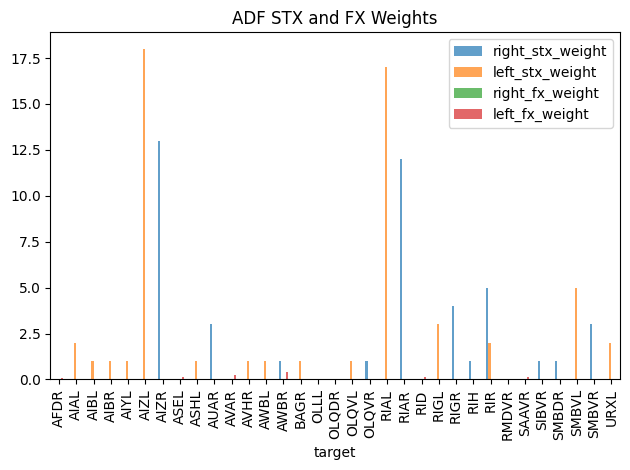

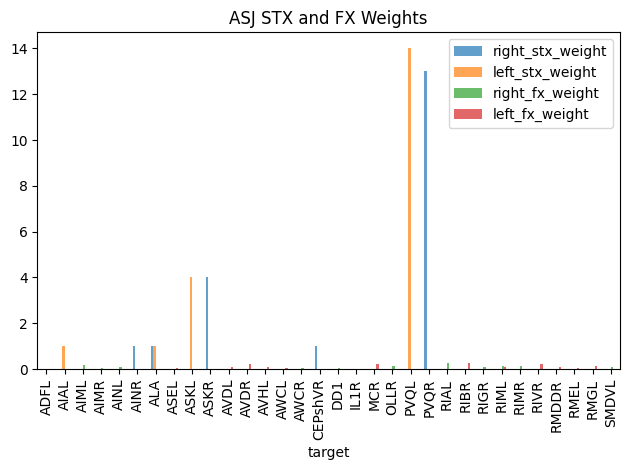

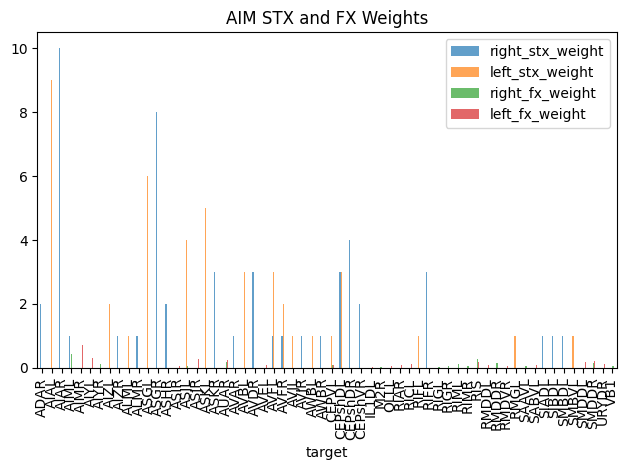

In [31]:
# plot sample distributions for ADF, ASJ, AIM

test_neurons = ['ADF', 'ASJ', 'AIM']

# plot stx and fx weights for each neuron
for neuron in test_neurons:
    neuron_db = connection_db[connection_db['neuron'] == neuron].sort_values(by='target')
    neuron_db.plot(
        x='target',
        y=['right_stx_weight', 'left_stx_weight', 'right_fx_weight', 'left_fx_weight'],
        kind='bar',
        alpha=0.7
    )
    plt.title(f"{neuron} STX and FX Weights")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

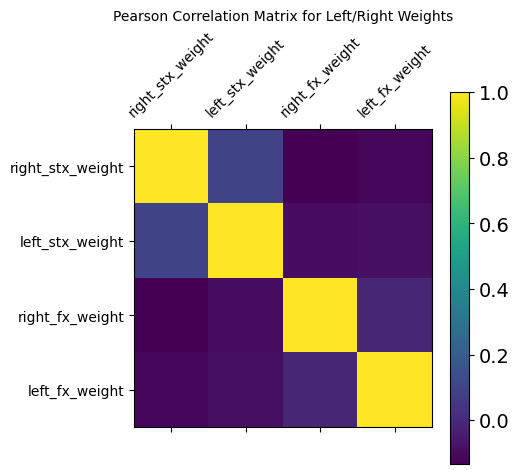

In [75]:
corr_matrix = connection_db.corr(method='pearson', numeric_only=True)
plt.matshow(corr_matrix)
plt.xticks(
    range(len(corr_matrix.columns)),
    corr_matrix.columns,
    rotation=45
)
plt.yticks(
    range(len(corr_matrix.columns)),
    corr_matrix.columns
)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Pearson Correlation Matrix for Left/Right Weights', fontsize=10)
plt.show()